In [0]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import math
import numpy as np
import h5py


In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount =True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## Helper Functions

import h5py
import numpy as np
import tensorflow as tf
import math

def load_dataset():
    train_dataset = h5py.File('/content/drive/My Drive/datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/drive/My Drive/datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    

In [13]:
## Compute Loss of one training exampple using TensorFlow
y_hat = tf.constant(36, name = 'y_hat')  # Define y_hat constant. Set to 36
y     = tf.constant(39, name = 'y')      # Define y. Set to 39

loss = tf.Variable((y-y_hat)**2, name = 'loss')  # Create a variable for loss
tf.compat.v1.disable_eager_execution()

init = tf.compat.v1.global_variables_initializer()  # When init is run later, the loss variable will be initialized and ready to be computed.

with tf.compat.v1.Session() as session:    # Create a session and print the output
  session.run(init)                        # Initialize the variables
  print(session.run(loss))                 # Prints the loss


## Writing and running programs in TF has the following steps (TensorFlow 1):
# 1. Create Tensors variables that are not yet executed/evaluated.
# 2. Write operations between those Tensors
# 3. Initialize your Tensors
# 4. Create a session
# 5. Run the session. This will run the operations you had written above.

a = tf.constant(2)
b = tf.constant(10)
c = tf.multiply(a,b)
print(c)
sess = tf.compat.v1.Session()
print(sess.run(c))

9
Tensor("Mul_1:0", shape=(), dtype=int32)
20


In [15]:
## A placeholder is an object whose value you can specipy only later. To specidy values for a placeholder, you can pass in values by using a "feed dictionary".
# Change the value of x in the feed_dict

x = tf.compat.v1.placeholder(tf.int64, name = 'x')
print(sess.run(2 * x, feed_dict = {x: 3}))
sess.close()

6


## Linear Function

In [0]:
def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- runs the session for Y = WX + b 
    """
    
    np.random.seed(1)
    
    """
    Note, to ensure that the "random" numbers generated match the expected results,
    please create the variables in the order given in the starting code below.
    """
    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.constant(np.random.randn(4,3), name = "W")
    b = tf.constant(np.random.randn(4,1), name = "b")
    Y = tf.add(tf.matmul(W,X), b)
    
    # Create the session using tf.Session() and run it with sess.run(...) on the variable you want to calculate
    sess = tf.compat.v1.Session()
    result = sess.run(Y)
    
    # close the session 
    sess.close()

    return result



## Computing the Sigmoid

In [0]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    
    # Create a placeholder for x. Name it 'x'.
    x = tf.compat.v1.placeholder(tf.float32, name = 'x')

    # compute sigmoid(x)
    sigmoid = tf.sigmoid(x)

    # Create a session, and run it. Please use the method 2 explained above. 
    # You should use a feed_dict to pass z's value to x. 
    sess = tf.compat.v1.Session()
    # Run session and call the output "result"
    result = sess.run(sigmoid, feed_dict = {x:z})
    sess.close()

    
    return result

## Computing the cost

In [0]:
# GRADED FUNCTION: cost

def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    # Create the placeholders for "logits" (z) and "labels" (y) 
    z = tf.placeholder(tf.float32, name = 'z')
    y = tf.placeholder(tf.float32, name = 'y')
    
    # Use the loss function 
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)
    
    # Create a session 
    sess = tf.Session()
    
    # Run the session.
    cost = sess.run(cost, feed_dict = {z:logits, y:labels})
    
    # Close the session.
    sess.close()
    
    return cost

## One-Hot Encoding

In [0]:
# GRADED FUNCTION: one_hot_matrix

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    # Create a tf.constant equal to C (depth)
    C = tf.constant(C, name = 'C' )
    
    # Use tf.one_hot, be careful with the axis
    one_hot_matrix = tf.one_hot(labels, depth = C, axis = 0)
    
    # Create the session
    sess = tf.Session()
    
    # Run the session
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session
    sess.close()
    
    return one_hot

## Initialize with zeros and ones

In [0]:
def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    # Create "ones" tensor using tf.ones(...)
    ones = tf.ones(shape)
    
    # Create the session
    sess = tf.Session()
    
    # Run the session to compute 'ones'
    ones = sess.run(ones)
    
    # Close the session.
    sess.close()

    return ones

# Building a Neural Network in TensorFlow

In [0]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 5


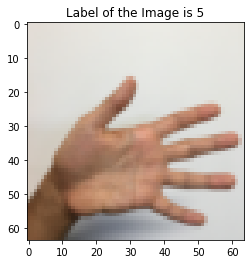

In [40]:
# Example of a picture
index = 0
plt.imshow(X_train_orig[index])
plt.title("Label of the Image is {}".format(np.squeeze(Y_train_orig[:, index])))
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [41]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


## Create placeholders

In [0]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    """
    X = tf.placeholder(shape=(n_x, None), dtype = tf.float32, name = "X") # None : because the number of examples in train/test is different.
    Y = tf.placeholder(shape=(n_y, None), dtype = tf.float32, name = "Y")
    
    return X, Y



## Initializing the parameters

In [0]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable(shape= (25,12288), name = "W1", initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable(shape= (25,1), name = "b1", initializer=tf.zeros_initializer())
    W2 = tf.get_variable(shape= (12,25), name = "W2", initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable(shape= (12,1), name = "b2", initializer=tf.zeros_initializer())
    W3 = tf.get_variable(shape= (6,12), name = "W3", initializer=tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable(shape= (6,1), name = "b3", initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

## Forward Propagation

In [0]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                                    # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                               # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                             # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)                               # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                             # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)                               # Z3 = np.dot(W3, A2) + b3
    
    return Z3

## Compute Cost

In [0]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels= labels))
    
    return cost

## Backward Propagation & parameter updates

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [48]:
parameters = model(X_train, Y_train, X_test, Y_test)

AttributeError: ignored